# Preprocessing danych

In [27]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

#data = pd.read_csv('merged_data.csv')
data = pd.read_csv('fifth-run/feats_version_5_22_acc.csv')
data = data[~data["activity"].str.contains("jogging")]
data["activity"] = data["activity"].replace(["sitting", "lying"], "resting")

data = data.reset_index(drop=True)

result = data[data["name"].str.contains("kuba")]

result_train = data[data["name"].str.contains("kuba") == False]

result_train.drop('name', axis=1, inplace=True)
result.drop('name', axis=1, inplace=True)


X_train = result_train.iloc[:, :-1].values
labels_train = result_train.iloc[:, -1].values

X_test = result.iloc[:, :-1].values
labels_test = result.iloc[:, -1].values
#print(labels_train)
#print(labels_test)

from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()

labels_train1 = encoder.fit_transform(labels_train)
#print(labels_train)

labels_test1 = encoder.transform(labels_test)
#np.set_printoptions(threshold=np.inf)
#print(labels_test1)
#labels_combined = [label_train for label_pair in zip(labels_train, labels_test1) for label_train in label_pair]


X_test, X_val, labels_test1, labels_val1 = train_test_split(X_test, labels_test1, test_size=0.5, random_state=42)

X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

print("Wielkość zbioru X Train: ", X_train.shape)
print("Wielkość zbioru X Test: ", X_test.shape)
print("Wielkość zbioru X Validation: ", X_val.shape)
print("Wielkość zbioru Y Train: ", labels_train1.shape)
print("Wielkość zbioru Y Test: ", labels_test1.shape)
print("Wielkość zbioru Y Validation: ", labels_val1.shape)

Wielkość zbioru X Train:  (2279, 115, 1)
Wielkość zbioru X Test:  (294, 115, 1)
Wielkość zbioru X Validation:  (295, 115, 1)
Wielkość zbioru Y Train:  (2279, 6)
Wielkość zbioru Y Test:  (294, 6)
Wielkość zbioru Y Validation:  (295, 6)


## to do wyrzucenia

In [4]:

from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout


X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

    
print("X Train shape: ", X_train.shape)
print("X Test shape: ", X_test.shape)
print("Y Train shape: ", labels_train1.shape)
print("Y Test shape: ", labels_test1.shape)

X Train shape:  (2279, 115, 1)
X Test shape:  (589, 115, 1)
Y Train shape:  (2279, 6)
Y Test shape:  (589, 6)


## Uczenie modelu

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 115, 32)           128       
                                                                 
 conv1d_20 (Conv1D)          (None, 115, 64)           6208      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 58, 64)           0         
 g1D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 58, 64)            0         
                                                                 
 flatten_9 (Flatten)         (None, 3712)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               1901056   
                                                     

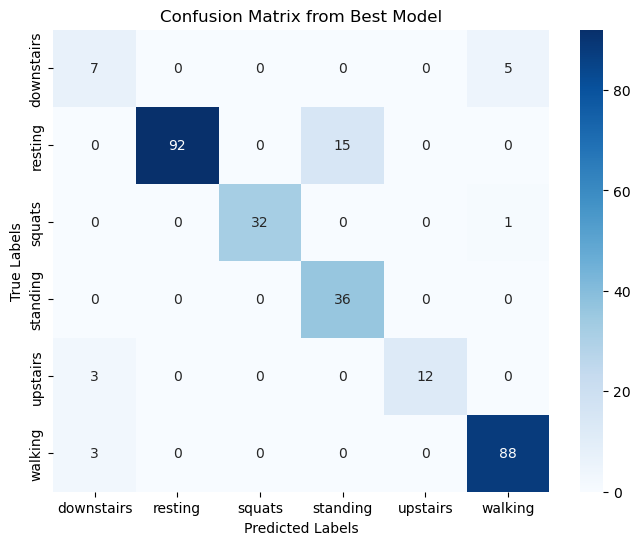

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout

from sklearn.metrics import classification_report, confusion_matrix
pd.options.mode.chained_assignment = None
# Create sequential model 
cnn_model = tf.keras.models.Sequential()

#First CNN layer  with 32 filters, conv window 3, relu activation and same padding
cnn_model.add(Conv1D(filters=32, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.000000000001), input_shape = (X_train.shape[1],1)))

#Second CNN layer  with 64 filters, conv window 3, relu activation and same padding
#cnn_model.add(Conv1D(filters=128, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.0000000000001)))

#Third CNN layer with 128 filters, conv window 3, relu activation and same padding
cnn_model.add(Conv1D(filters=64, kernel_size=(3,), padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.00000000000001)))

#Fourth CNN layer with Max pooling
cnn_model.add(MaxPool1D(pool_size=(3,), strides=2, padding='same'))
cnn_model.add(Dropout(0.1))

#Flatten the output
cnn_model.add(Flatten())

#Add a dense layer with 256 neurons
cnn_model.add(Dense(units = 512, activation=tf.keras.layers.LeakyReLU(alpha=0.01)))

#Add a dense layer with 512 neurons
#cnn_model.add(Dense(units = 128, activation=tf.keras.layers.LeakyReLU(alpha=0.9)))

#Softmax as last layer with five outputs
cnn_model.add(Dense(units = 6, activation='softmax'))

cnn_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()


[print(i.shape, i.dtype) for i in cnn_model.inputs]
[print(o.shape, o.dtype) for o in cnn_model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in cnn_model.layers]


class_mapping = {
    0: "downstairs",  # Replace with your actual class name or label
    1: "resting",
    2: "squats",
    3: "standing",
    4: "upstairs",
    5:  "walking" }

listt =[]
for key in class_mapping.values():
    listt.append(key)

class BestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.best_accuracy = 0.0  

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
    
    def on_train_end(self, logs=None):
        print(f"Best Validation Accuracy: {self.best_accuracy * 100:.2f}%")


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.01,  # Monitor validation accuracy
    patience=60,  # Number of epochs without improvement before stopping
    restore_best_weights=True
)
    
    
# Define a callback to save the model with the best validation accuracy
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='najlepszy_model_CNN.h5',  # Filepath to save the best model
    monitor='val_accuracy',    # Monitor validation accuracy
    save_best_only=True,       # Save only the best model
   # verbose=1
)

# Train the model with the callback
cnn_model_history = cnn_model.fit(
    X_train, labels_train1, epochs=100, batch_size=100,
    validation_data=(X_test, labels_test1),
    callbacks=[early_stopping_callback, model_checkpoint],
    verbose = 1 # Include the model checkpoint callback
)

# Load the best model
best_model = tf.keras.models.load_model('najlepszy_model_CNN.h5')

# Make predictions using the best model
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
labels_test_categorical = np.argmax(labels_test1, axis=1)

# Generate and print the classification report
classification_rep = classification_report(labels_test_categorical, y_pred_classes, target_names=listt)
print("Classification Report from Best Model:\n", classification_rep)

# Generate and print the confusion matrix
confusion_mtx = confusion_matrix(labels_test_categorical, y_pred_classes)
print("Confusion Matrix from Best Model:\n", confusion_mtx)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=listt, yticklabels=listt)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix from Best Model')
plt.show()




10/10 [==============================] - 0s 4ms/step
Classification Report from Best Model:
               precision    recall  f1-score   support

  downstairs       0.71      0.83      0.77        12
     resting       1.00      1.00      1.00       107
      squats       1.00      1.00      1.00        33
    standing       1.00      1.00      1.00        36
    upstairs       1.00      0.80      0.89        15
     walking       0.98      0.99      0.98        91

    accuracy                           0.98       294
   macro avg       0.95      0.94      0.94       294
weighted avg       0.98      0.98      0.98       294



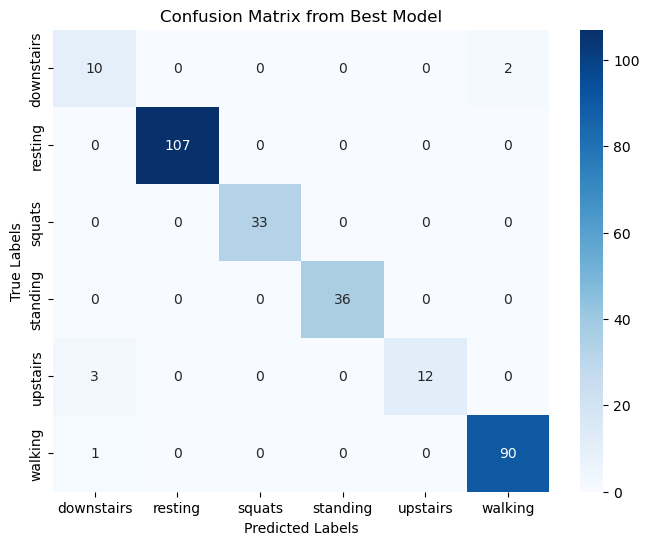

In [16]:
# Load the best model
best_model = tf.keras.models.load_model('best_model2.h5')

# Make predictions using the best model
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
labels_test_categorical = np.argmax(labels_test1, axis=1)

# Generate and print the classification report
classification_rep = classification_report(labels_test_categorical, y_pred_classes, target_names=listt)
print("Classification Report from Best Model:\n", classification_rep)

# Generate and print the confusion matrix
#confusion_mtx = confusion_matrix(labels_test_categorical, y_pred_classes)
#print("Confusion Matrix from Best Model:\n", confusion_mtx)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=listt, yticklabels=listt)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix from Best Model')
plt.show()


10/10 [==============================] - 0s 3ms/step
Weighted Recall : 0.9217687074829932
Accuracy: 0.9217687074829932
Classification Report:
               precision    recall  f1-score   support

  downstairs       0.86      0.50      0.63        12
     resting       1.00      0.86      0.92       107
      squats       1.00      0.97      0.98        33
    standing       0.71      1.00      0.83        36
    upstairs       0.94      1.00      0.97        15
     walking       0.94      0.99      0.96        91

    accuracy                           0.92       294
   macro avg       0.91      0.89      0.88       294
weighted avg       0.94      0.92      0.92       294



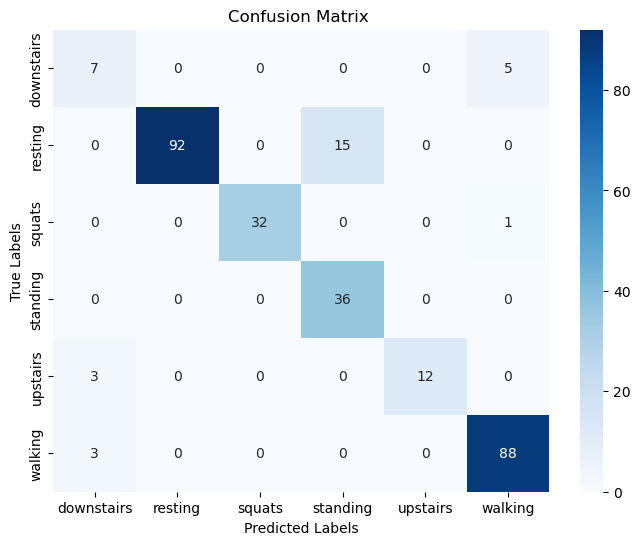

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
best_model = tf.keras.models.load_model('best_model_TEST.h5')
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

labels_test_categorical = np.argmax(labels_test1, axis=1)

accuracy = accuracy_score(labels_test_categorical, y_pred_classes)
print("Accuracy:", accuracy)

class_report = classification_report(labels_test_categorical, y_pred_classes, target_names=listt)
print("Classification Report:\n", class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=listt, yticklabels=listt)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix ')
plt.show()

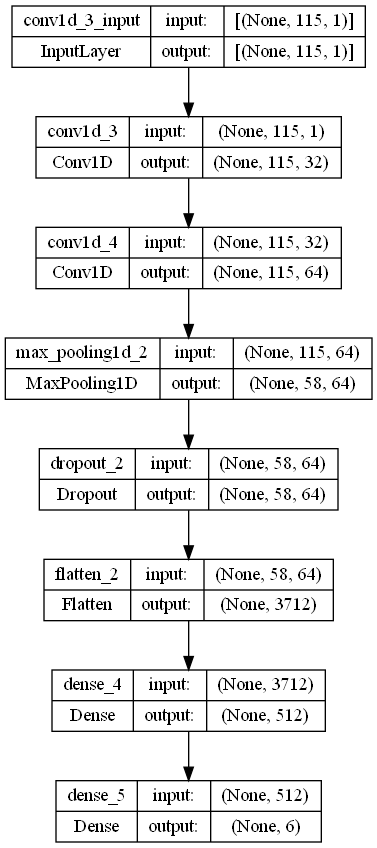

In [7]:
from tensorflow.keras.utils import plot_model

# Save a graphical representation of the model to a file
plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

# Alternatively, you can display the graphical representation in a Jupyter notebook
from IPython.display import Image

Image('cnn_model.png')









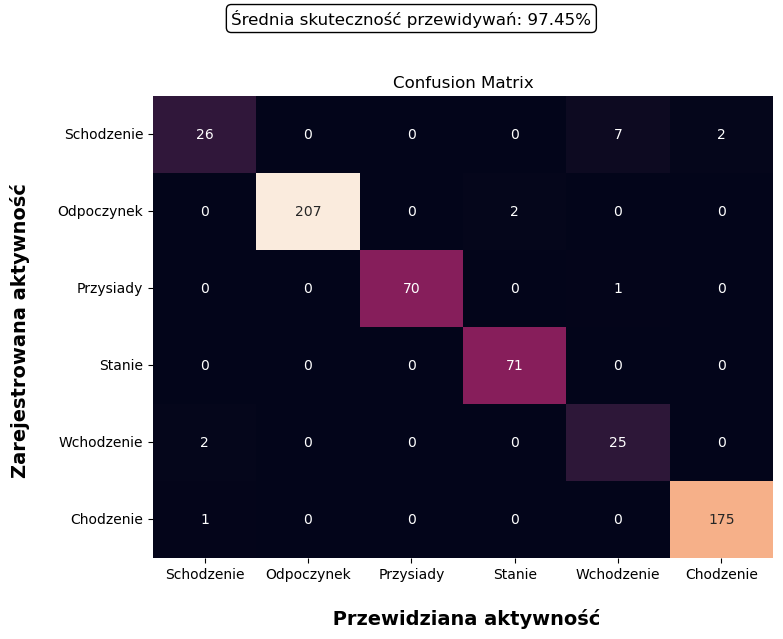

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your confusion matrix and other code
confusion_mtx = np.array([[26, 0, 0, 0, 7, 2],
                         [0, 207, 0, 2, 0, 0],
                         [0, 0, 70, 0, 1, 0],
                         [0, 0, 0, 71, 0, 0],
                         [2, 0, 0, 0, 25, 0],
                         [1, 0, 0, 0, 0, 175]])  # Replace with your confusion matrix data
polish_labels = ['Schodzenie', 'Odpoczynek', 'Przysiady', "Stanie", "Wchodzenie", "Chodzenie"]

# Generate a custom colormap
#cmap = sns.color_palette(['white' if value != 26 and value != 207 and value != 70 and value != 71 and value != 25 and value != 175 else 'red' for value in confusion_mtx.flatten()], as_cmap=True)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=polish_labels, yticklabels=polish_labels, cbar=False)
plt.xlabel('\n Przewidziana aktywność', fontsize=14, fontweight='bold')
plt.ylabel('Zarejestrowana aktywność \n', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix')

# Calculate the position for the center
x_center = (len(polish_labels) - 1) / 2
y_center = -1

# Add a text box for displaying accuracy in the center
accuracy = 0.9745  # Replace with your accuracy value
plt.text(x_center, y_center, f'Średnia skuteczność przewidywań: {float(accuracy) * 100:.2f}%', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

plt.show()



209
71
71
27
Int64Index([429, 430, 431, 432, 433, 434, 435, 436, 437, 439, 440, 441, 442,
            443],
           dtype='int64')
Int64Index([822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834,
            835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847,
            848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860,
            861, 862, 863, 864, 865, 866, 867, 868, 869],
           dtype='int64')
6/6 [==============================] - 0s 3ms/step
Classification Report from Best Model:
               precision    recall  f1-score   support

  downstairs       0.91      0.74      0.82        27
     resting       1.00      1.00      1.00        27
      squats       1.00      1.00      1.00        27
    standing       1.00      1.00      1.00        27
    upstairs       0.83      0.93      0.88        27
     walking       0.93      1.00      0.96        27

    accuracy                           0.94       162
   macro avg       0.95   

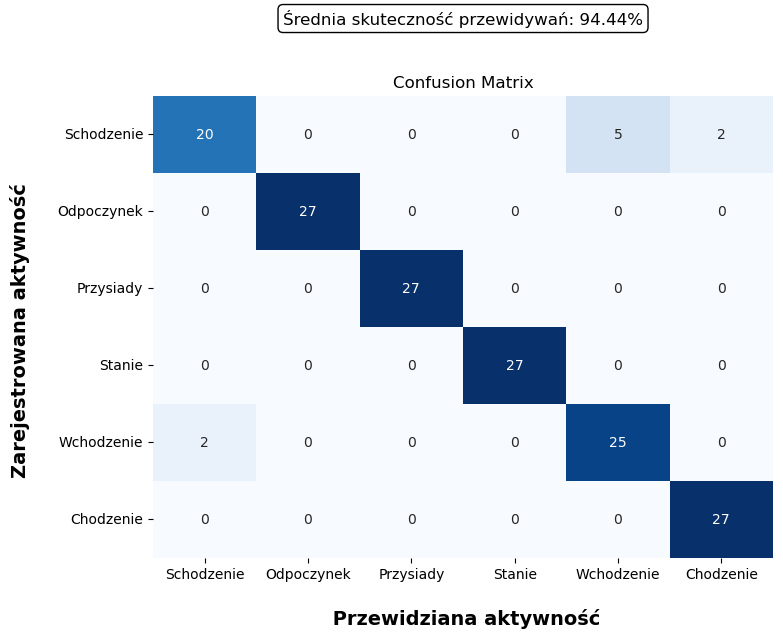

In [71]:
#wyniki do preezentacji z  ilością danych = 27

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')

#data = pd.read_csv('merged_data.csv')
data = pd.read_csv('fifth-run/feats_version_5_22_acc.csv')
data = data[~data["activity"].str.contains("jogging")]
data["activity"] = data["activity"].replace(["sitting", "lying"], "resting")

data = data.reset_index(drop=True)

result = data[data["name"].str.contains("kuba")]

result_train = data[data["name"].str.contains("kuba") == False]

result_train.drop('name', axis=1, inplace=True)
result.drop('name', axis=1, inplace=True)


#count_downstairs = len(result[result['activity'] == 'downstairs'])

class_labels = [ "resting", "squats", "standing", "upstairs"]

# Define how many lines you want to drop (e.g., 150 lines)
lines_to_drop = 167

for i in class_labels:
    count_downstairs = len(result[result['activity'] == f'{i}'])
    print(count_downstairs)

# Check if there are enough lines to drop
    if count_downstairs > 27:
        # Find the indices of rows with activity 'downstairs' to drop
        indices_to_drop = result[result['activity'] == f'{i}'].head(count_downstairs-27).index
        #print(indices_to_drop)
    
        # Drop the rows with activity 'downstairs'
        result = result.drop(indices_to_drop)
#if count_downstairs > 27:



#dropping downstairs
indices_to_drop = result[result['activity'] == "downstairs"].iloc[14:15].index 
result = result.drop(indices_to_drop)



indices_to_drop = result[result['activity'] == "downstairs"].iloc[28:29].index 
result = result.drop(indices_to_drop)


indices_to_drop = result[result['activity'] == "downstairs"].iloc[1:7].index 
result = result.drop(indices_to_drop)



count_downstairs = len(result[result['activity'] == "downstairs"])
# Find the indices of rows with activity 'downstairs' to drop
indices_to_drop = result[result['activity'] == "downstairs"].tail(count_downstairs-40).index
print(indices_to_drop)










#Dropping walking
indices_to_drop = result[result['activity'] == "walking"].tail(101).index
result = result.drop(indices_to_drop)


count_downstairs = len(result[result['activity'] == "walking"])
# Find the indices of rows with activity 'downstairs' to drop
indices_to_drop = result[result['activity'] == "walking"].head(count_downstairs-27).index
print(indices_to_drop)


# Drop the rows with activity 'downstairs'
result = result.drop(indices_to_drop)

        
X_train = result_train.iloc[:, :-1].values
labels_train = result_train.iloc[:, -1].values

X_test = result.iloc[:, :-1].values
labels_test = result.iloc[:, -1].values
#print(labels_train)
#print(labels_test)

from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()

labels_train1 = encoder.fit_transform(labels_train)
#print(labels_train)

labels_test1 = encoder.transform(labels_test)




best_model = tf.keras.models.load_model('Best_model_97%_goodupstairs.h5')

# Make predictions using the best model
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
labels_test_categorical = np.argmax(labels_test1, axis=1)

# Generate and print the classification report
classification_rep = classification_report(labels_test_categorical, y_pred_classes, target_names=listt)
print("Classification Report from Best Model:\n", classification_rep)



import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score




# Calculate the accuracy
accuracy = accuracy_score(labels_test_categorical, y_pred_classes)

polish_labels = ['Schodzenie', 'Odpoczynek', 'Przysiady', "Stanie", "Wchodzenie", "Chodzenie"]  # Replace with your Polish labels

confusion_mtx = confusion_matrix(labels_test_categorical, y_pred_classes)
#print(condusion_mtx)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=polish_labels, yticklabels=polish_labels, cbar=False)  # Add cbar=False to remove the color bar
plt.xlabel('\n Przewidziana aktywność', fontsize=14, fontweight='bold')  # Increase fontsize and make it bold
plt.ylabel('Zarejestrowana aktywność \n', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix')

# Calculate the position for the center
x_center = len(polish_labels)-5  / 2 - 0.5
y_center = -1

# Add a text box for displaying accuracy in the center
plt.text(x_center, y_center, f'Średnia skuteczność przewidywań: {float(accuracy )*100:.2f}%', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

plt.show()
        

19/19 [==============================] - 0s 3ms/step
Classification Report from Best Model:
               precision    recall  f1-score   support

  downstairs       0.90      0.74      0.81        35
     resting       1.00      0.99      1.00       209
      squats       1.00      0.99      0.99        71
    standing       0.97      1.00      0.99        71
    upstairs       0.76      0.93      0.83        27
     walking       0.99      0.99      0.99       176

    accuracy                           0.97       589
   macro avg       0.94      0.94      0.94       589
weighted avg       0.98      0.97      0.97       589



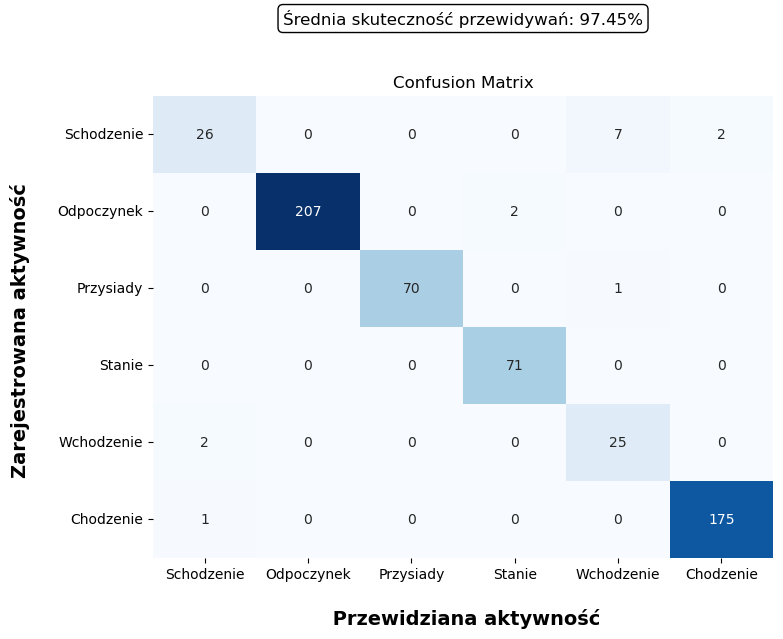

In [9]:
best_model = tf.keras.models.load_model('Best_model_97%_goodupstairs.h5')

# Make predictions using the best model
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels back to categorical labels
labels_test_categorical = np.argmax(labels_test1, axis=1)

# Generate and print the classification report
classification_rep = classification_report(labels_test_categorical, y_pred_classes, target_names=listt)
print("Classification Report from Best Model:\n", classification_rep)



import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score




# Calculate the accuracy
accuracy = accuracy_score(labels_test_categorical, y_pred_classes)

polish_labels = ['Schodzenie', 'Odpoczynek', 'Przysiady', "Stanie", "Wchodzenie", "Chodzenie"]  # Replace with your Polish labels

confusion_mtx = confusion_matrix(labels_test_categorical, y_pred_classes)
#print(condusion_mtx)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=polish_labels, yticklabels=polish_labels, cbar=False)  # Add cbar=False to remove the color bar
plt.xlabel('\n Przewidziana aktywność', fontsize=14, fontweight='bold')  # Increase fontsize and make it bold
plt.ylabel('Zarejestrowana aktywność \n', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix')

# Calculate the position for the center
x_center = len(polish_labels)-5  / 2 - 0.5
y_center = -1

# Add a text box for displaying accuracy in the center
plt.text(x_center, y_center, f'Średnia skuteczność przewidywań: {float(accuracy )*100:.2f}%', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

plt.show()

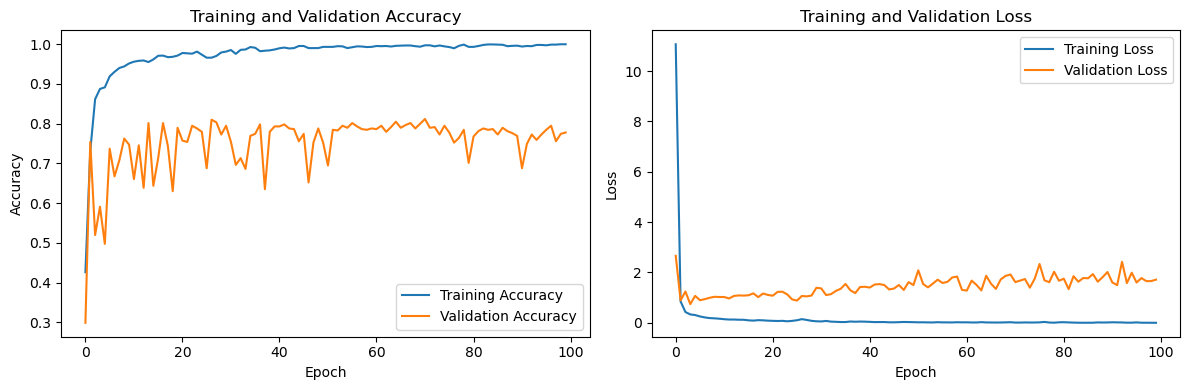

In [107]:
training_accuracy = cnn_model_history.history['accuracy']
validation_accuracy = cnn_model_history.history['val_accuracy']
training_loss = cnn_model_history.history['loss']
validation_loss = cnn_model_history.history['val_loss']

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [1]:
#chechikng for specific activity to test
upstairs_rows = data11[data11["activity"] == "lying"].index[0]
print(upstairs_rows)

NameError: name 'data11' is not defined

In [93]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Load the best-trained model (if you haven't already)
best_model = tf.keras.models.load_model('best_model.h5')

# Load the data from the CSV file
data11 = pd.read_csv('fifth-run/feats_version_5_1_acc.csv')
data11 = data[~data["activity"].str.contains("jogging")]
data11 = data11.reset_index(drop=True)


counst =[]
aa = []
number_avg = 6


# Select a specific line (window) based on the index
for i in range (50):
    #print(i)
    index_to_select = i  # Change to the index of the desired line/window


    selected_window = data11.iloc[index_to_select, :]
    print("actual activity: ",selected_window["activity"])
    # Drop columns 'name' and 'activity' if they are not needed
    selected_window = selected_window.drop("name")
    selected_window = selected_window.drop("activity")

    # Convert the selected window data to a NumPy array
    window_data = selected_window.values.reshape(1, -1)  # Reshape to match the input shape of your model

    # Normalize or preprocess the data if necessary
    # You might need to apply the same preprocessing that you used during training.

    # Convert NumPy array to a TensorFlow tensor
    window_data_tensor = tf.convert_to_tensor(window_data, dtype=tf.float64)  # Adjust the dtype if needed

    # Make predictions using the loaded model
    y_pred = best_model.predict(window_data_tensor)

    # Assuming your model performs multi-class classification, you can get the class with the highest probability
    predicted_class = np.argmax(y_pred)

    class_mapping = {
        0: "downstairs",  # Replace with your actual class name or label
        1: "lying",
        2: "sitting",
        3: "squats",
        4: "standing",
        5: "upstairs",
        6:  "walking" }

    
    print("\nPredicted Class:", class_mapping[predicted_class])
    
    ########################################
    #Prediction on avarage last 6 outputs
    if len(aa) > number_avg:
        aa.pop(0)
    aa.append(class_mapping[predicted_class])
    #print(aa)
    
    element_counts = Counter(aa)
    element_indices = {}

    for index, element in enumerate(reversed(aa)):
        if element in element_indices:
            continue  # Skip elements already indexed
        element_indices[element] = index

    # Find the most common element closest to the right
    most_common_element = max(element_counts, key=lambda x: (element_counts[x], -element_indices[x]))

    print("Prediction (avarage) : ", most_common_element, "\n")
    
    
    

actual activity:  upstairs
1/1 [==============================] - 0s 104ms/step

Predicted Class: upstairs
Prediction (avarage) :  upstairs 

actual activity:  upstairs
1/1 [==============================] - 0s 22ms/step

Predicted Class: upstairs
Prediction (avarage) :  upstairs 

actual activity:  upstairs
1/1 [==============================] - 0s 21ms/step

Predicted Class: upstairs
Prediction (avarage) :  upstairs 

actual activity:  upstairs
1/1 [==============================] - 0s 21ms/step

Predicted Class: upstairs
Prediction (avarage) :  upstairs 

actual activity:  upstairs
1/1 [==============================] - 0s 20ms/step

Predicted Class: upstairs
Prediction (avarage) :  upstairs 

actual activity:  upstairs
1/1 [==============================] - 0s 21ms/step

Predicted Class: upstairs
Prediction (avarage) :  upstairs 

actual activity:  upstairs
1/1 [==============================] - 0s 20ms/step

Predicted Class: upstairs
Prediction (avarage) :  upstairs 

actual activ

In [91]:
from collections import Counter

list = [1,1,1,1,2,2,2,3,3,4,4,4,4,4,4,5,5,5,1,1,1,1,1,1,1,1,2,2,5,2,2,2,2,2]
counst =[]
aa = []
number_avg = 6

for i in range(50):
    #print(list[i])
    #counst.append(list[i])
    
    if len(aa) > number_avg:
        aa.pop(0)
    aa.append(class_mapping[predicted_class])
    print(aa)
    
    element_counts = Counter(aa)
    element_indices = {}

    for index, element in enumerate(reversed(aa)):
        if element in element_indices:
            continue  # Skip elements already indexed
        element_indices[element] = index

    # Find the most common element closest to the right
    most_common_element = max(element_counts, key=lambda x: (element_counts[x], -element_indices[x]))

    print("Most common element:", most_common_element, "\n")


    
print(counterr)     

['downstairs']
Most common element: downstairs 

['downstairs', 'downstairs']
Most common element: downstairs 

['downstairs', 'downstairs', 'downstairs']
Most common element: downstairs 

['downstairs', 'downstairs', 'downstairs', 'downstairs']
Most common element: downstairs 

['downstairs', 'downstairs', 'downstairs', 'downstairs', 'downstairs']
Most common element: downstairs 

['downstairs', 'downstairs', 'downstairs', 'downstairs', 'downstairs', 'downstairs']
Most common element: downstairs 

['downstairs', 'downstairs', 'downstairs', 'downstairs', 'downstairs', 'downstairs', 'downstairs']
Most common element: downstairs 

['downstairs', 'downstairs', 'downstairs', 'downstairs', 'downstairs', 'downstairs', 'downstairs']
Most common element: downstairs 

['downstairs', 'downstairs', 'downstairs', 'downstairs', 'downstairs', 'downstairs', 'downstairs']
Most common element: downstairs 

['downstairs', 'downstairs', 'downstairs', 'downstairs', 'downstairs', 'downstairs', 'downstairs'

NameError: name 'counterr' is not defined

In [88]:
data = pd.read_csv('fifth-run/feats_version_5_22_acc.csv')
data = data[~data["activity"].str.contains("jogging")]
data["activity"] = data["activity"].replace(["sitting", "lying"], "resting")

data = data.reset_index(drop=True)

# Count the number of lines with activity 'downstairs'
count_downstairs = len(data[data['activity'] == 'downstairs'])

class_labels = ["downstairs", "resting", "squats", "standing", "upstairs", "walking"]

# Define how many lines you want to drop (e.g., 150 lines)
lines_to_drop = 167

for i in class_labels:
    count_downstairs = len(data[data['activity'] == f'{i}'])
    print(count_downstairs)

# Check if there are enough lines to drop
    if count_downstairs > 185:
        # Find the indices of rows with activity 'downstairs' to drop
        indices_to_drop = data[data['activity'] == f'{i}'].head(count_downstairs-185).index
    
        # Drop the rows with activity 'downstairs'
        data = data.drop(indices_to_drop)
    



#for i in class_labels:
data11 = len(data[data['activity'] == f'{i}'])
    #print("  \n" ,count_downstairs)

194
997
260
284
185
948


In [69]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

# Load the best-trained model (if you haven't already)
best_model = tf.keras.models.load_model('best_model.h5')

# Load the data from the CSV file
# data11 = pd.read_csv('fifth-run/feats_version_5_1_acc.csv')
# data11 = data[~data["activity"].str.contains("jogging")]
# data11 = data11.reset_index(drop=True)

#################
data = pd.read_csv('fifth-run/feats_version_5_22_acc.csv')
data = data[~data["activity"].str.contains("jogging")]
data["activity"] = data["activity"].replace(["sitting", "lying"], "resting")
data = data.reset_index(drop=True)
data11 = data[data["name"].str.contains("kuba")]

true_labels = []
predicted_labels = []

# Select a specific line (window) based on the index
for i in range(580):
    selected_window = data11.iloc[i, :]
    true_activity = selected_window["activity"]
    true_labels.append(true_activity)

    # Drop columns 'name' and 'activity' if they are not needed
    selected_window = selected_window.drop("name")
    selected_window = selected_window.drop("activity")

    # Convert the selected window data to a NumPy array
    window_data = selected_window.values.reshape(1, -1)  # Reshape to match the input shape of your model

    # Convert NumPy array to a TensorFlow tensor
    window_data_tensor = tf.convert_to_tensor(window_data, dtype=tf.float64)  # Adjust the dtype if needed

    # Make predictions using the loaded model
    y_pred = best_model.predict(window_data_tensor)

    # Assuming your model performs multi-class classification, you can get the class with the highest probability
    predicted_class = np.argmax(y_pred)
    predicted_labels.append(predicted_class)

# Convert both true and predicted labels to string labels
true_labels = [str(label) for label in true_labels]
predicted_labels = [str(label) for label in predicted_labels]

# Generate the classification report
report = classification_report(true_labels, predicted_labels)

# Print or use the report as needed
print(report)


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
           6       0.00      0.00      0.00       0.0
  downstairs       0.00      0.00      0.00      35.0
     resting       0.00      0.00      0.00     209.0
      squats       0.00      0.00      0.00      71.0
    standing       0.00      0.00      0.00      71.0
    upstairs       0.00      0.00      0.00      27.0
     walking       0.00      0.00      0.00     167.0

    accuracy                           0.00     580.0
   macro avg       0.00      0.00      0.00     580.0
weighted avg       0.00      0.00      0.00     580.0



In [31]:
from keras.models import load_model

# Wczytaj model
loaded_model = load_model('best_model1.h5')

# Wyświetl strukturę modelu
print("Model Summary:")
print(loaded_model.summary())

# Wyświetl wagi modelu
for layer in loaded_model.layers:
    print("\nLayer:", layer.name)
    for weight in layer.get_weights():
        print(weight.shape)
        print(weight)

Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 115, 32)           128       
                                                                 
 conv1d_1 (Conv1D)           (None, 115, 64)           6208      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 58, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 58, 64)            0         
                                                                 
 flatten (Flatten)           (None, 3712)              0         
                                                                 
 dense (Dense)               (None, 512)               1901056   
                                         